# 4.Using the 1D inference
In this tutorial, we will show how to:
- Define sources and transformations for 1D spectra
- Use the 1D inference to fit with a CES spectrum 
- Search for a monoenergetic signal from Xe133 and flat backgrounds

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import scipy.stats as stats
from tqdm import tqdm

# use the latest inference_interface to allow 1d hist!
sys.path.insert(0, "/home/yuem/xenon_package/inference_interface")
from inference_interface import multihist_to_template, template_to_multihist
from alea.utils import get_file_path
from alea.models import BlueiceExtendedModel

## 4.1 Load the example yaml config and have a look
In the example we include 3 components:
- Xe133: a histogram based source
- test_gaussian: a monoenergic source
- test_flat: a flat source

#### 4.1a parameter_defination
This part is all the same as what we did in the previous notebooks - include all of your parameters and their information

#### 4.1b likelihood_config
Here we need to do a little bit more:
- Define the transformations applied, the model for those transformations, and related parameters. For details you can check `ces_transformation.py`, in which we include the basic transformations (efficiency, smearing and bias) 
- For each kind of source, we need to provide the specific information needed

For example, here we set:
- apply_efficiency = True, efficiency_model = "constant", efficiency_parameters = "efficiency"

The transformation parameter(s) must fit the chosen model and must appear in the parameter defination. Most of the time they should appear as shape parameteres with blueice anchors. Otherwise the speed of the fitting will be decreased dramatically.

In [14]:
import yaml

example_model_config_path = get_file_path("unbinned_ces_simple.yaml")
with open(example_model_config_path, "r") as f:
    example_model_config = yaml.load(f, Loader=yaml.FullLoader)
example_model_config["likelihood_config"]

{'template_folder': None,
 'likelihood_terms': [{'name': 'science_run_0',
   'default_source_class': 'alea.ces_source.CESTemplateSource',
   'likelihood_type': 'blueice.likelihood.UnbinnedLogLikelihood',
   'analysis_space': [{'ces': 'np.arange(0, 500, 1)'}],
   'minimal_energy_resolution': 0.1,
   'apply_efficiency': True,
   'efficiency_model': 'constant',
   'efficiency_parameters': ['efficiency_constant'],
   'apply_smearing': True,
   'smearing_model': 'gaussian',
   'smearing_parameters': ['smearing_a', 'smearing_b'],
   'apply_bias': False,
   'livetime_parameter': 'livetime',
   'fiducial_mass_parameter': 'fiducial_mass',
   'slice_args': {},
   'sources': [{'name': 'xe133',
     'histname': 'xe133_template',
     'parameters': ['xe133_rate_multiplier',
      'smearing_a',
      'smearing_b',
      'efficiency_constant'],
     'template_filename': 'xe133_template.ii.h5'},
    {'name': 'test_gaussian',
     'class': 'alea.ces_source.CESMonoenergySource',
     'peak_energy': 300,

Let's look into the sources. The specific information (other than rate multipliers) needed by those basic sources are:
- histogram-based: template_filename
- flat: None
- monoenergetic: peak_energy

In [15]:
example_model_config["likelihood_config"]["likelihood_terms"][0]["sources"]

[{'name': 'xe133',
  'histname': 'xe133_template',
  'parameters': ['xe133_rate_multiplier',
   'smearing_a',
   'smearing_b',
   'efficiency_constant'],
  'template_filename': 'xe133_template.ii.h5'},
 {'name': 'test_gaussian',
  'class': 'alea.ces_source.CESMonoenergySource',
  'peak_energy': 300,
  'parameters': ['test_gaussian_rate_multiplier',
   'smearing_a',
   'smearing_b',
   'efficiency_constant']},
 {'name': 'test_flat',
  'class': 'alea.ces_source.CESFlatSource',
  'parameters': ['test_flat_rate_multiplier', 'efficiency_constant']}]

## 4.2 Build the model based on the config
This is all the same as previous notebooks

In [16]:
example_model = BlueiceExtendedModel.from_config(example_model_config_path)

True


building data generators: 100%|██████████| 1/1 [00:00<00:00, 35.00it/s]


In [17]:
source_name_list = example_model.get_source_name_list(likelihood_name="science_run_0")
source_name_list

['xe133', 'test_gaussian', 'test_flat']

By looking at the expectation of sources, we can find that the efficiency (nominal value=0.9) is applied

In [18]:
example_model.get_expectation_values()

{'test_flat': 3999.5996505975872,
 'test_gaussian': 1200.0,
 'xe133': 3999.999999999999}

## 4.3 Simulate some data and fit with it
We can see that the smearing is correctly applied. 

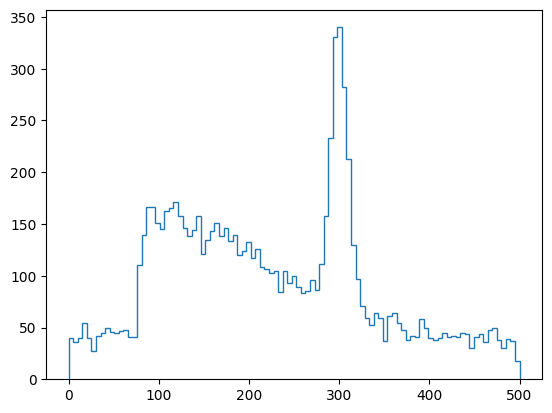

In [19]:
data = example_model.generate_data()
example_model.data = data
plt.hist(data["science_run_0"]["ces"], bins=np.linspace(0, 500, 100), histtype="step")
plt.show()

The fitted values are consistent with the nominal values that we set (1000, 1000 and 300)

In [20]:
best_fit, max_ll = example_model.fit()
best_fit

{'livetime': 365.0,
 'fiducial_mass': 4.0,
 'xe133_rate_multiplier': 964.9541328200681,
 'test_flat_rate_multiplier': 1032.0157388960008,
 'test_gaussian_rate_multiplier': 306.3813658149087,
 'smearing_a': 24.78655566413668,
 'smearing_b': 1.5051788780248918,
 'efficiency_constant': 0.7556960758230736}

## 4.4 Find the confidence interval of fitted rate_multipliers
It's the same as what we did in `2_fitting_and_ci`

In [21]:
fitted_gs_rate = best_fit["test_gaussian_rate_multiplier"]
gs_rates = np.linspace(0.8 * fitted_gs_rate, 1.2 * fitted_gs_rate, 20)
ll_vals_c = np.zeros((len(gs_rates)))

for i, gs_rate in tqdm(enumerate(gs_rates)):
    _, ll_val_c = example_model.fit(test_gaussian_rate_multiplier=gs_rate)
    ll_vals_c[i] = ll_val_c

20it [00:03,  5.33it/s]


Text(0, 0.5, 'q(s)')

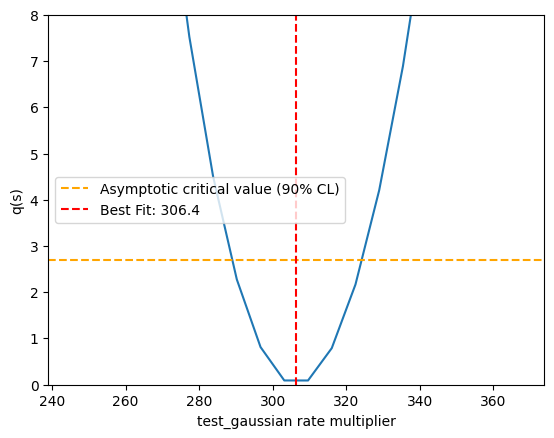

In [22]:
x = gs_rates
y = 2 * (max_ll - ll_vals_c)
confidence_level = 0.9
# Plot
plt.plot(x, y)
plt.axhline(
    stats.chi2(1).ppf(confidence_level),
    label="Asymptotic critical value (90% CL)",
    c="orange",
    ls="--",
)

plt.axvline(fitted_gs_rate, label=f"Best Fit: {fitted_gs_rate:.1f}", c="red", ls="--")
plt.ylim(0, 8)
plt.legend()
plt.xlabel("test_gaussian rate multiplier")
plt.ylabel("q(s)")

## 4.5 Find the fitted smearing model
As we mentioned before, the transformation parameters can also be set as "fittable" and therefore we can check if the data conflicts with the transformations. 

In [23]:
a_vals = np.linspace(0.99 * best_fit["smearing_a"], 1.01 * best_fit["smearing_a"], 10)
b_vals = np.linspace(0.95 * best_fit["smearing_b"], 1.05 * best_fit["smearing_b"], 10)

ll_vals_c = np.zeros((len(a_vals), len(b_vals)))

for i, a in tqdm(enumerate(a_vals)):
    for j, b in enumerate(b_vals):
        _, ll_val_c = example_model.fit(smearing_a=a, smearing_b=b)
        ll_vals_c[i, j] = ll_val_c

10it [00:14,  1.47s/it]


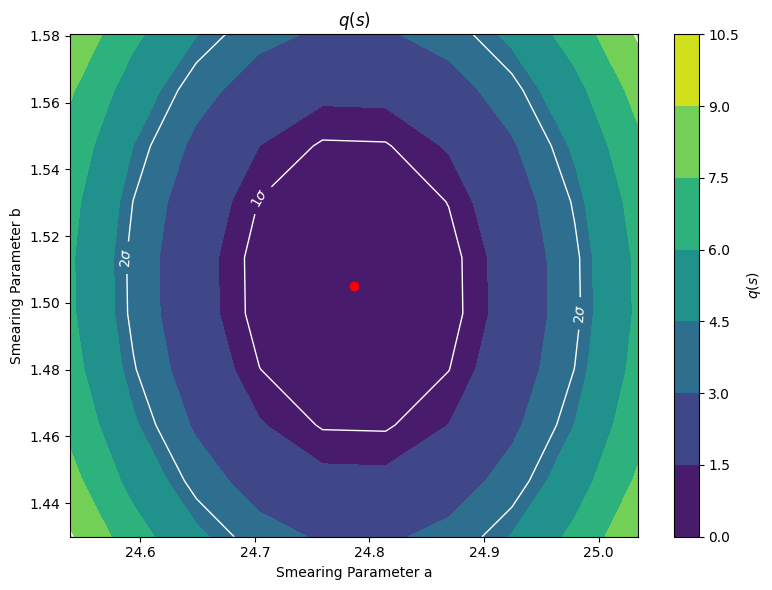

In [24]:
plt.figure(figsize=(8, 6))
plt.contourf(a_vals, b_vals, 2 * (max_ll - ll_vals_c).T, cmap="viridis")
plt.colorbar(label="$q(s)$")

contours = plt.contour(
    a_vals, b_vals, 2 * (max_ll - ll_vals_c).T, colors="white", linewidths=1, levels=[1, 4, 9]
)
sigma_levels = {1: r"1$\sigma$", 4: r"2$\sigma$", 9: r"3$\sigma$"}
plt.clabel(contours, inline=True, fontsize=10, fmt=sigma_levels)

plt.scatter(best_fit["smearing_a"], best_fit["smearing_b"], color="red")
plt.xlabel("Smearing Parameter a")
plt.ylabel("Smearing Parameter b")
plt.title("$q(s)$")
plt.tight_layout()
plt.show()